# Helper Methods

In [1]:
import numpy as np

color_latency="#ff7f0e"
color_tps="#1f77b4"
color_runtime="#8c564b"

# outlier removal method: IQR
# returns list without outliers
# http://colingorrie.github.io/outlier-detection.html
# https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
def remove_outliers_iqr(data):
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    iqr = quartile_3 - quartile_1
    cut_off = (iqr * 1.5)
    lower_bound = quartile_1 - cut_off
    upper_bound = quartile_3 + cut_off
    # identify outliers
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in data if x >= lower_bound and x <= upper_bound]
    print('Non-outlier observations: %d' % len(outliers_removed))
    return outliers_removed

# annotates plt with y values
def plot_annotate(plt,xvalues,yvalues):
    for i,j in zip(xvalues, yvalues):
        plt.annotate(str(np.round(j,1)),xy=(i-0.15,j))
    
def autolabel_barchart(rects,axis):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axis.text(rect.get_x() + rect.get_width()/2., 0.90*height,'%.1f' % round(float(height),1),ha='center', va='bottom')

# PyMongo Query

db = "test"
collection = "benchmarklogs"

In [2]:
from pymongo import MongoClient
client = MongoClient()

db = client['test']
collection = db['benchmarklogs']

# PyMongo Query ->Pandas DataFrame

In [3]:
import numpy as np
import pandas as pd

query = {"$and":[{"$or":[{"miningOnFullWorkload":False}, {"miningOnFullWorkload":True}]},{"approach":3}, {"instanceType":"c5.4xlarge"}, {"nodes":1}, {"usedGenesisJson":"genesis_poa_max_performance.json"}, {"maxTransactions": 1000}, {"docker":False}, {"scenario":"account"}]}

# Make a query to the specific DB and Collection
cursor = collection.find(query)

# Expand the cursor and construct the DataFrame
df = pd.DataFrame(list(cursor))

sample_size = len(df.index)
print("Number of rows:" + str(sample_size))

Number of rows:300


# Pandas DataFrame -> Plot
## Throughput and Latency

In [4]:
import matplotlib.pyplot as plt

data_tps = df[['txPerSecond','miningOnFullWorkload']]
data_latency = df[['averageDelay','miningOnFullWorkload']]
data_runtime = df[['runtime','miningOnFullWorkload']]

title_tps = "Throughput against Mining/Sealing Approach \n (1 Node, PoA, Period 1 sec, max GasLimit, n=" + str(sample_size) + ")"
title_latency = "Latency against Mining/Sealing Approach \n (1 Node, PoA, Period 1 sec, max GasLimit n=" + str(sample_size) + ")"

ylabel_tps = "Transactions Per Second (TPS)"
ylabel_latency = "Transaction Latency [seconds]"

#objects = list(['TPS', 'Latency'])

dataFalse_tps = data_tps.loc[df['miningOnFullWorkload'] == False].iloc[:,0]
dataTrue_tps = data_tps.loc[df['miningOnFullWorkload'] == True].iloc[:,0]

dataFalse_latency = data_latency.loc[df['miningOnFullWorkload'] == False].iloc[:,0]
dataTrue_latency = data_latency.loc[df['miningOnFullWorkload'] == True].iloc[:,0]

# REMOVE OUTLIERS
dataFalse_tps = pd.Series(remove_outliers_iqr(dataFalse_tps))
dataTrue_tps = pd.Series(remove_outliers_iqr(dataTrue_tps))
dataFalse_latency = pd.Series(remove_outliers_iqr(dataFalse_latency))
dataTrue_latency = pd.Series(remove_outliers_iqr(dataTrue_latency))

data_tps = [dataFalse_tps, dataTrue_tps]
data_latency = [dataFalse_latency, dataTrue_latency]

print("TPS miningOnFullWorkload False mean: " + str(dataFalse_tps.mean()))
print("TPS miningOnFullWorkload False median: " + str(dataFalse_tps.median()))
print("Latency miningOnFullWorkload False mean: " + str(dataFalse_latency.mean()))
print("Latency miningOnFullWorkload False median: " + str(dataFalse_latency.median()))
print("\n")
print("TPS miningOnFullWorkload True mean: " + str(dataTrue_tps.mean()))
print("TPS miningOnFullWorkload True median: " + str(dataTrue_tps.median()))
print("Latency miningOnFullWorkload True mean: " + str(dataTrue_latency.mean()))
print("Latency miningOnFullWorkload True median: " + str(dataTrue_latency.median()))
print("\n")

Identified outliers: 4
Non-outlier observations: 96
Identified outliers: 0
Non-outlier observations: 200
Identified outliers: 18
Non-outlier observations: 82
Identified outliers: 3
Non-outlier observations: 197
TPS miningOnFullWorkload False mean: 327.6997960620029
TPS miningOnFullWorkload False median: 328.0839895013123
Latency miningOnFullWorkload False mean: 2.1007638414634138
Latency miningOnFullWorkload False median: 2.107185999999996


TPS miningOnFullWorkload True mean: 772.1978837982033
TPS miningOnFullWorkload True median: 702.7410357306532
Latency miningOnFullWorkload True mean: 0.96322761928934
Latency miningOnFullWorkload True median: 0.8402009999999996




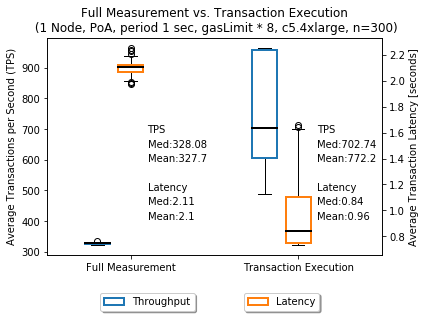

In [5]:
fig = plt.figure()

## the data
N = 2
## necessary variables
ind = np.arange(N)
#print(ind)
# Create an axes instance
ax1 = fig.add_subplot(111)

ax1.set_title("Full Measurement vs. Transaction Execution\n (1 Node, PoA, period 1 sec, gasLimit * 8, c5.4xlarge, n=" + str(sample_size) + ")")
#ax1.set_xlabel(xlabel)
ax1.set_ylabel("Average Transactions per Second (TPS)")

# Create the boxplot
bp = ax1.boxplot(data_tps,labels=["Standard mining/sealing","Mining/Sealing on full workload"], positions=ind+0.1, patch_artist=True, manage_xticks=True)

ax2 = ax1.twinx()
bp2 = ax2.boxplot(data_latency,labels=["Standard mining/sealing","Mining/Sealing on full workload"], positions=ind+0.3, patch_artist=True, manage_xticks=True)
#ax1.set_xticks(ind + 0.5/2)
ax2.set_ylabel("Average Transaction Latency [seconds]")
ax1.set_xticklabels(('Full Measurement', 'Transaction Execution'))

#ax1.set_ylim(bottom=9.5, top=11.5)
#ax2.set_ylim(bottom=45, top=57)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color=color_tps, linewidth=2)
    # change fill color
    box.set( facecolor = 'w' )
    
## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color="k", linewidth=2) 
    
## change outline color, fill color and linewidth of the boxes
for box in bp2['boxes']:
    # change outline color
    box.set( color=color_latency, linewidth=2)
    # change fill color
    box.set( facecolor = 'w' )
    
## change color and linewidth of the medians
for median in bp2['medians']:
    median.set(color="k", linewidth=2) 

plt.figtext(0.3575, 0.55,  'TPS', color='black')
plt.figtext(0.3575, 0.5, 'Med:' + str(round(dataFalse_tps.median(),2)), color='black')
plt.figtext(0.3575, 0.45, 'Mean:' + str(round(dataFalse_tps.mean(),2)), color='black')
plt.figtext(0.3575, 0.35,  'Latency', color='black')
plt.figtext(0.3575, 0.3, 'Med:' + str(round(dataFalse_latency.median(),2)), color='black')
plt.figtext(0.3575, 0.25,  'Mean:' + str(round(dataFalse_latency.mean(),2)), color='black')

plt.figtext(0.75, 0.55,  'TPS', color='black')
plt.figtext(0.75, 0.5, 'Med:' + str(round(dataTrue_tps.median(),2)), color='black')
plt.figtext(0.75, 0.45, 'Mean:' + str(round(dataTrue_tps.mean(),2)), color='black')
plt.figtext(0.75, 0.35,  'Latency', color='black')
plt.figtext(0.75, 0.3, 'Med:' + str(round(dataTrue_latency.median(),2)), color='black')
plt.figtext(0.75, 0.25,  'Mean:' + str(round(dataTrue_latency.mean(),2)), color='black')

ax1.legend([bp["boxes"][0]],["Throughput"],bbox_to_anchor=(0.3, -0.15),fancybox=True,shadow=True,loc="upper center")
ax2.legend([bp2["boxes"][0]],["Latency"],bbox_to_anchor=(0.7, -0.15),fancybox=True,shadow=True,loc="upper center")

fig.savefig("result_bottleneck_transaction_execution.svg", format="svg")

In [6]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

from scipy import stats

alpha = 0.05
t,p = stats.ttest_ind(dataFalse_tps,dataTrue_tps,equal_var=False)
print("p = {:g}".format(p))
if(p<alpha):
    print("H0 is rejected = there IS a significant difference in throughput")
else:
    print("H0 valid = there is NO significant difference in throughput")

p = 1.39213e-85
H0 is rejected = there IS a significant difference in throughput


In [7]:
t,p = stats.ttest_ind(dataFalse_latency,dataTrue_latency,equal_var=False)

print("p = {:g}".format(p))
if(p<alpha):
    print("H0 is rejected = there IS a significant difference in latency")
else:
    print("H0 valid = there is NO significant difference in latency")

p = 7.64295e-138
H0 is rejected = there IS a significant difference in latency


# Runtime Analysis

Text(0.65,0.55,'Mean:1.38')

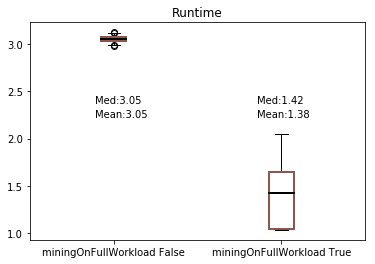

In [8]:
runtimeFalse = data_runtime.loc[df['miningOnFullWorkload'] == False].iloc[:,0]
runtimeTrue = data_runtime.loc[df['miningOnFullWorkload'] == True].iloc[:,0]

#print('miningOnFullWorkload False Med:' + str(round(runtimeFalse.median(),2)))
#print('miningOnFullWorkload True Med:' + str(round(runtimeTrue.median(),2)))

fig = plt.figure()

# Create an axes instance
ax = fig.add_subplot(111)

ax.set_title("Runtime")
#ax.set_xlabel(xlabel)
#ax.set_ylabel(ylabel)

# Create the boxplot
bp = ax.boxplot([runtimeFalse,runtimeTrue],labels=["miningOnFullWorkload False","miningOnFullWorkload True"], patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set(color=color_runtime, linewidth=2)
    # change fill color
    box.set(facecolor="w")
    
## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color="k", linewidth=2) 
    
plt.figtext(0.275, 0.6, 'Med:' + str(round(runtimeFalse.median(),2)), color='black')
plt.figtext(0.275, 0.55, 'Mean:' + str(round(runtimeFalse.mean(),2)), color='black')

plt.figtext(0.65, 0.6, 'Med:' + str(round(runtimeTrue.median(),2)), color='black')
plt.figtext(0.65, 0.55, 'Mean:' + str(round(runtimeTrue.mean(),2)), color='black')
    
#fig.savefig("runtime.svg", format="svg")